# Posterior Mean Estimator (PyTorch)

This code defines two PyTorch modules:

## 1. `MLP` (Multi-Layer Perceptron)

A simple feedforward neural network with ReLU activations and dropout.

**Architecture:**
- Input → Linear → ReLU → Dropout  
- Hidden → Linear → ReLU → Dropout  
- Output → Linear  



## 2. Summary Layer (CNN)

The summary layer is a **1D convolutional feature extractor** that transforms sequential input into a set of learned summary statistics.  

**Pipeline:**
1. **Input:**  
   - Shape: `(batch_size, 1, sequence_length)`  
   - The extra dimension `1` is the **channel dimension**, since Conv1D expects input as `(batch, channels, length)`.  

2. **Conv1D (1 → summary_channels):**  
   - Kernel size = `summary_kernel_size`  
   - Padding = `summary_kernel_size // 2` (keeps the same sequence length).  
   - Produces `summary_channels` feature maps.  
   - Followed by **ReLU** nonlinearity.  

3. **Conv1D (summary_channels → summary_channels):**  
   - Another convolution with the same number of channels.  
   - Again uses padding to maintain length.  
   - Followed by **ReLU** nonlinearity.  

4. **Conv1D (summary_channels → summary_stats):**  
   - Final convolution that reduces the channels down to `summary_stats`.  
   - No activation (linear output).  
   - Output shape: `(batch_size, summary_stats, sequence_length)`  




In [1]:
# Imports

import torch
from torch import nn
from global_utils import generate_data
from matplotlib import pyplot as plt

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.nn(x)


class PosteriorMeanEstimator(nn.Module):
    def __init__(
        self,
        summary_stats=32,
        summary_kernel_size=3,
        summary_channels=64,
        estimator_width=128,
        output_dim=2,
        dropout=0.0
    ):
        super().__init__()

        # Convnet summary layer
        padding = summary_kernel_size // 2
        self.summary = nn.Sequential(
            nn.Conv1d(1, summary_channels, summary_kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(summary_channels, summary_channels, summary_kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(summary_channels, summary_stats, summary_kernel_size, padding=padding),
        )
        # MLP estimator layer
        self.estimator = MLP(summary_stats, output_dim, hidden_dim=estimator_width, dropout=dropout)

    def forward(self, x):
        # We add an extra dimension to the input to set the number of input channels to one
        x_summary = self.summary(x)
        # We sum the summary statistics across all observations, then apply the estimator
        x_estimate = self.estimator(x_summary.sum(-1))
        return x_estimate


# Training of neural network

## `train_NN`

The `train_NN` function trains a `PosteriorMeanEstimator` neural network on simulated data. An example usage shows it training on an arbitrary batch size, number of epochs, learning rate and dropout.

In [8]:
def train_NN(NN=None, n_epochs=128, n_batches_per_epoch=128, training_batch_size=128, lr=0.00001, dropout=0.01, process="d", observations="s", device="cpu"):
    NN = PosteriorMeanEstimator(dropout=dropout).to(device) if NN is None else NN
    NN.to(device)
    y_test, _, x_test = generate_data(N=300, days=100, batch_size=1024, process=process, observations=observations, beta=None, gamma=None)
    y_test = y_test.to(device)
    x_test = x_test.to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(NN.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        y_epoch_batches, _, x_epoch_batches = generate_data(
            N=300, days=100, batch_size=n_batches_per_epoch * training_batch_size, process=process, observations=observations, beta=None, gamma=None
        )
        y_epoch_batches = y_epoch_batches.to(device)
        x_epoch_batches = x_epoch_batches.to(device)

        for batch_idx in range(n_batches_per_epoch):
            batch_idx_start = batch_idx * training_batch_size
            batch_idx_end = batch_idx_start + training_batch_size
            y_batch = y_epoch_batches[batch_idx_start:batch_idx_end]
            x_batch = x_epoch_batches[batch_idx_start:batch_idx_end]

            optimizer.zero_grad()
            y_pred = NN(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / n_batches_per_epoch
        with torch.no_grad():
            y_pred_test = NN(x_test)
            test_loss = loss_fn(y_pred_test, y_test).item()

        train_losses.append(avg_epoch_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    return NN, train_losses, test_losses


trained_NN, train_losses, test_losses = train_NN(NN=None, n_epochs=250, n_batches_per_epoch=60, training_batch_size=128, lr=0.00001, dropout=0.01, process="d", observations="s")


Epoch 1/250, Train Loss: 3.4475, Test Loss: 1.5484
Epoch 2/250, Train Loss: 0.7196, Test Loss: 0.1611
Epoch 3/250, Train Loss: 0.0857, Test Loss: 0.0640
Epoch 4/250, Train Loss: 0.0645, Test Loss: 0.0568
Epoch 5/250, Train Loss: 0.0612, Test Loss: 0.0558
Epoch 6/250, Train Loss: 0.0552, Test Loss: 0.0517
Epoch 7/250, Train Loss: 0.0543, Test Loss: 0.0513
Epoch 8/250, Train Loss: 0.0550, Test Loss: 0.0513
Epoch 9/250, Train Loss: 0.0519, Test Loss: 0.0499
Epoch 10/250, Train Loss: 0.0496, Test Loss: 0.0480
Epoch 11/250, Train Loss: 0.0471, Test Loss: 0.0451
Epoch 12/250, Train Loss: 0.0438, Test Loss: 0.0443
Epoch 13/250, Train Loss: 0.0411, Test Loss: 0.0421
Epoch 14/250, Train Loss: 0.0384, Test Loss: 0.0344
Epoch 15/250, Train Loss: 0.0348, Test Loss: 0.0350
Epoch 16/250, Train Loss: 0.0319, Test Loss: 0.0323
Epoch 17/250, Train Loss: 0.0305, Test Loss: 0.0308
Epoch 18/250, Train Loss: 0.0298, Test Loss: 0.0294
Epoch 19/250, Train Loss: 0.0276, Test Loss: 0.0258
Epoch 20/250, Train L

## Evaluation Function: `evaluate_NN`

The `evaluate_NN` function evaluates a trained neural network (`PosteriorMeanEstimator`) on a newly generated test dataset and visualizes the quality of predictions.

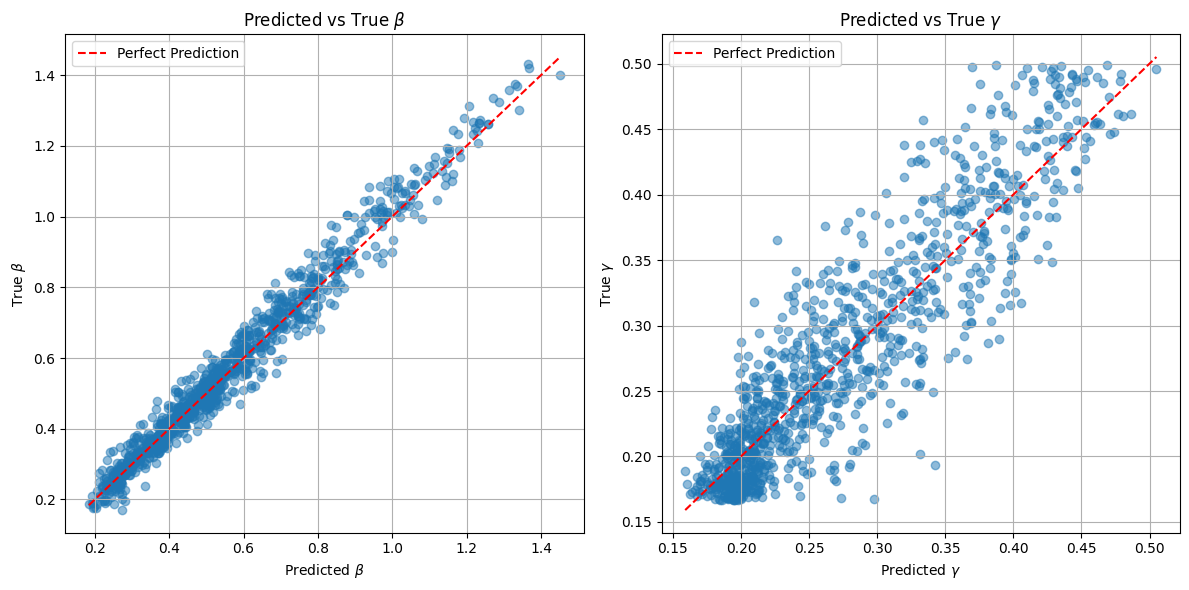

Test Loss: 0.0016


In [9]:
def evaluate_NN(NN, testSize=1024, device="cpu", x_test=None, y_test=None):
    NN.to(device)
    NN.eval()
    if x_test is None or y_test is None:
        y_test, _, x_test = generate_data(N=300, days=100, batch_size=testSize)
    y_test = y_test.to(device)
    x_test = x_test.to(device)

    loss_fn = nn.MSELoss()

    with torch.no_grad():
        y_pred_test = NN(x_test)
        test_loss = loss_fn(y_pred_test, y_test).item()

    # Move to CPU and convert to NumPy
    y_test = y_test.detach().cpu().numpy()
    y_pred_test = y_pred_test.detach().cpu().numpy()

    # Separate beta and gamma
    beta_true, gamma_true = y_test[:, 0], y_test[:, 1]
    beta_pred, gamma_pred = y_pred_test[:, 0], y_pred_test[:, 1]


    # Create subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot beta (predicted on x-axis, true on y-axis)
    axes[0].scatter(beta_pred, beta_true, alpha=0.5)
    axes[0].plot([beta_pred.min(), beta_pred.max()],
                [beta_pred.min(), beta_pred.max()],
                'r--', label='Perfect Prediction')
    axes[0].set_xlabel('Predicted $\\beta$')
    axes[0].set_ylabel('True $\\beta$')
    axes[0].set_title('Predicted vs True $\\beta$')
    axes[0].grid(True)
    axes[0].legend()

    # Plot gamma
    axes[1].scatter(gamma_pred, gamma_true, alpha=0.5)
    axes[1].plot([gamma_pred.min(), gamma_pred.max()],
                [gamma_pred.min(), gamma_pred.max()],
                'r--', label='Perfect Prediction')
    axes[1].set_xlabel('Predicted $\\gamma$')
    axes[1].set_ylabel('True $\\gamma$')
    axes[1].set_title('Predicted vs True $\\gamma$')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return test_loss


test_loss = evaluate_NN(NN=trained_NN)
print(f"Test Loss: {test_loss:.4f}")

### `plot_losses(train_losses, test_losses, startfrom=0)`

This function visualizes training and testing loss curves over epochs.

#### Parameters:
- **train_losses** (`list` or `array`): Training loss values recorded at each epoch.  
- **test_losses** (`list` or `array`): Testing/validation loss values recorded at each epoch.  
- **startfrom** (`int`, default=0): Index from which to start plotting

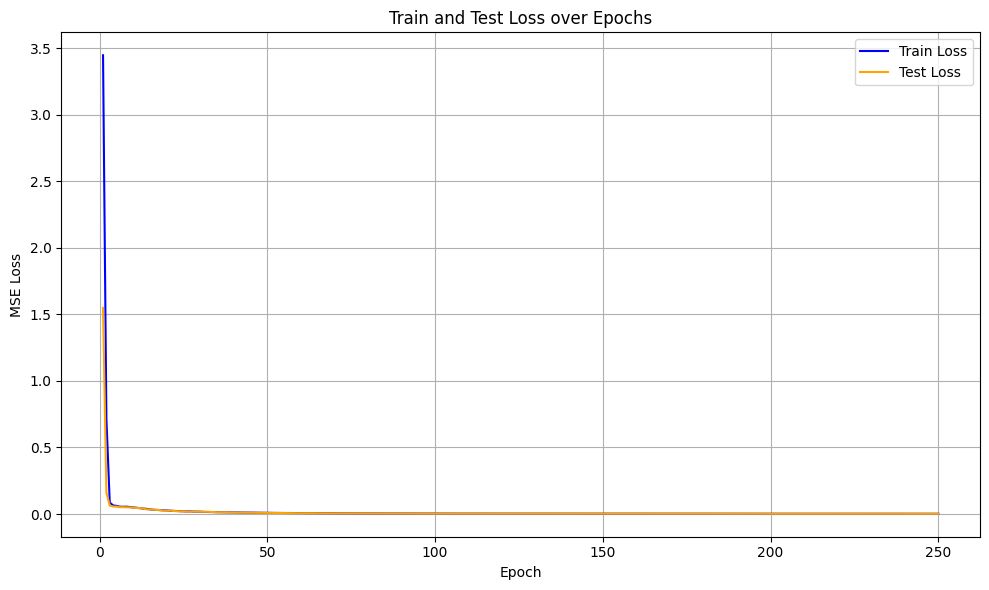

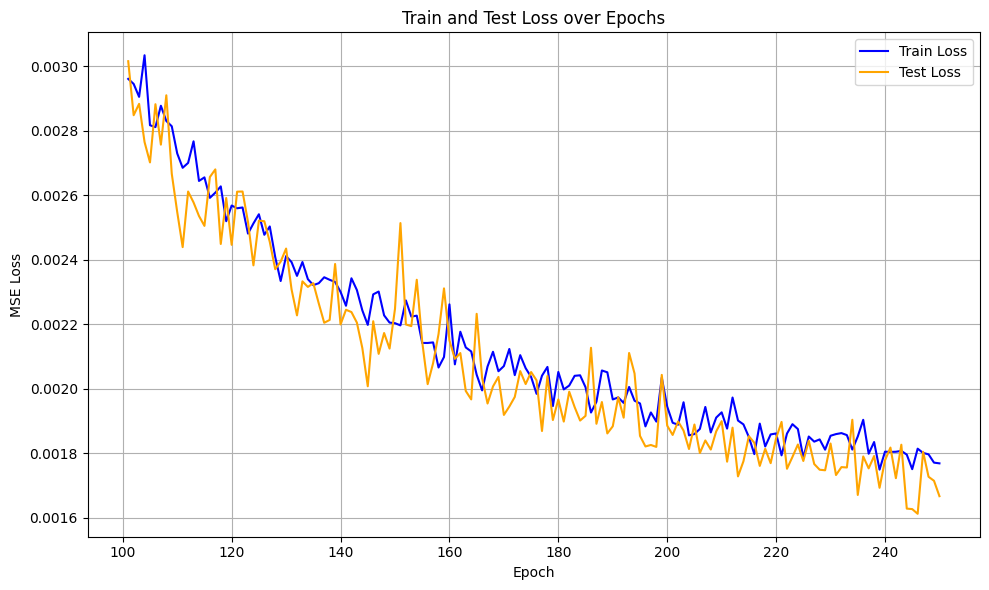

In [12]:
def plot_losses(train_losses, test_losses, startfrom=0):
    train_losses = train_losses[startfrom:]
    test_losses = test_losses[startfrom:]
    epochs = range(1+startfrom, startfrom + len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, test_losses, label='Test Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Train and Test Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_losses(train_losses, test_losses, startfrom=0)
plot_losses(train_losses, test_losses, startfrom=100)